# ADA Project - DataBrewers

The aim of this project is to analyze beer preference shifts across seasons and events, with a focus on understanding consumer trends in taste, aroma, palate, and appearance. By examining variation in ratings for beer style and alcohol content among US users, and comparing different states with varying weather conditions, we seek to identify seasonal trends. To deepen our understanding, we will conduct sentiment analysis to capture the tone of reviews and references to seasons, weather, or events, and correlate these insights with ratings. Our findings will provide actionable insights for professionals (brewers, marketers, etc.) by highlighting customer preferences throughout the year. Understanding these seasonal trends enables brewers to adjust product offerings to align more closely with consumer demand. As a conclusion of to our research, we could suggest the best beer that would be the perfect match for each season/festivity, in the form of a time fresco. 

## Data pre-processing 


In [1]:
import pandas as pd
import tarfile
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sns
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import re
import wordcloud
import nltk
import sys
from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

The exploratory analysis is detailed in the notebook `data_cleaning.ipynb`. We decided to choose only the BeerAdvocate dataset, as it contains a sufficient number of user ratings and reviews. By analyzing the country of origin from the users, we discovered that most of the ratings were provided by users from the United States. Therefore, we restricted the dataset to include only American reviews.
 
 The complete processing and cleaning workflow is implemented in `src/scripts/preprocessing.py`. In this script, we begin by loading the raw data files for beers, reviews, users, breweries, and ratings. User location is split into country and state, and non-US users are filtered out. We then assign a US region (e.g. Northeast, Midwest) to each entry based on the user's state. Beer styles are simplified by removing country prefixes like "Belgian" or "American" and reclassified into broader categories using a style map. The script also categorizes beer based on their Alcohol By Volume (ABV) values, dividing them into three categories (low, medium, and high) using a quantile-based thresholds. We assign a season to each reviews based on the month it was published (e.g. Spring, Summer, Fall, Winter). The dataset is filtered to only include years with at least 70,000 reviews. Missing values in the rating column are handled by removing rows where ratings are missing. Finally, the cleaned versions of the datasets are saved as compressed `csv`files in the `data/cleaned/`directory. 

In [2]:
# Run the preprocessing script
# %run src/scripts/preprocessing.py

#### Loading the data

In [3]:
reviews = pd.read_csv('./data/cleaned/reviews.csv.gz', compression='gzip')
print("reviews loaded")
ratings = pd.read_csv('./data/cleaned/ratings.csv.gz', compression='gzip')
print("ratings loaded")
users = pd.read_csv('./data/cleaned/users.csv.gz', compression='gzip')
print("users loaded")
beers_ba = pd.read_csv('./data/cleaned/beers.csv.gz', compression='gzip')
print("beers loaded")
breweries_ba = pd.read_csv('./data/cleaned/breweries.csv.gz', compression='gzip')
print("breweries loaded")

reviews loaded
ratings loaded
users loaded
beers loaded
breweries loaded


## Semantic analysis

In [4]:
import src.scripts.sentiment_analysis as sa

### Tokenisation
Here we tokenise and clean the reviews so we can use them later



In [5]:
clean_reviews = sa.get_cleaned_reviews(reviews)

100%|██████████| 2048878/2048878 [11:47<00:00, 2897.25it/s] 
c:\Users\marin\Documents\ma1\ada-2024-project-databrewers\src\scripts\sentiment_analysis.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_clean['cleaned_tokens'] = reviews_clean ['text'].progress_apply(preprocess_text)


### Occurences of Words
Here simply count the frequency of words appearing in our reviews here again we select just a few

In [6]:
top_20_words,word_freq = sa.top_n_words(clean_reviews, 20)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\marin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Processing: 100%|██████████| 253627098/253627098 [04:15<00:00, 992571.19it/s] 


### General Wordcloud
We generate a simple wordcloud to get the idea our distribution

In [7]:
sa.gen_wordcloud(word_freq,Title="Top 20 words in reviews")

TypeError: gen_wordcloud() got an unexpected keyword argument 'Title'

With juste a glance we can see a lot of words around the taste and the aroma we know we can direct our analysis on those


### Sentiment Analysis of the reviews
We want to get an idea of the type of words used to describe certain negative of positive traits


Classifying words...


Word Classification Progress: 100%|██████████| 5000/5000 [00:00<00:00, 250083.71it/s]


Word classification completed.
Number of positive words among the top 5000 words: 419
Number of negative words among the top 5000 words: 256


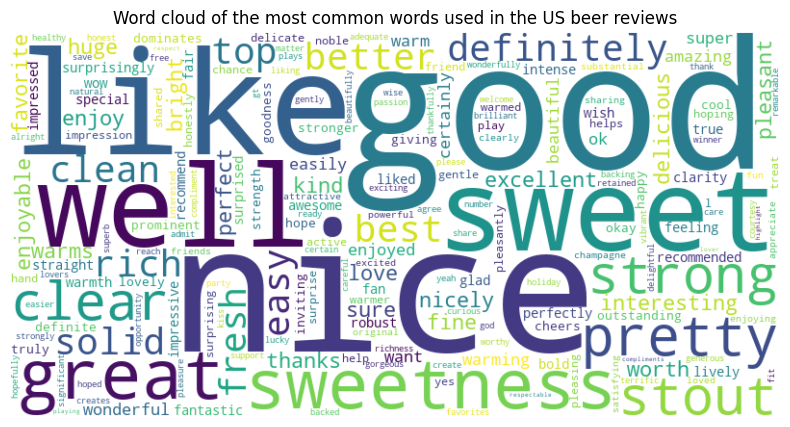

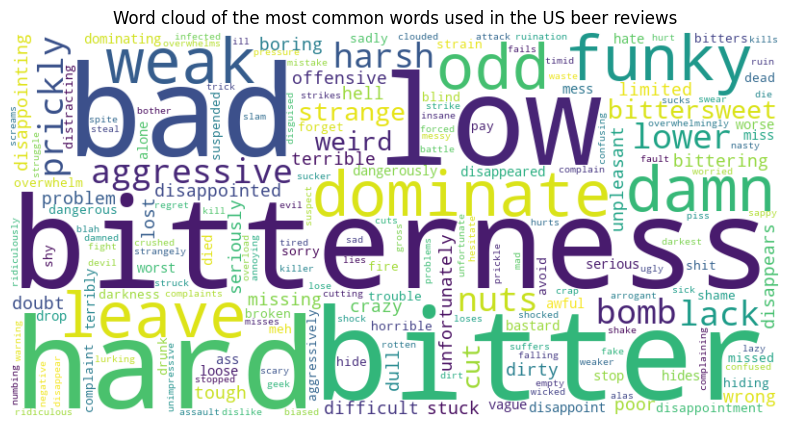

In [9]:
sa.sentiment_analysis(word_freq)

### Flavour Analysis
We want to count the occurences of certain "taste" related descriptive words for beers with a good grade, to see if can understand our tastes relative to the months


In [18]:
from sklearn.feature_extraction.text import CountVectorizer


# count the number of times each flavour appears in the reviews for each flavour
def count_flavour_occurrences(text, flavour):
    count = text.count(flavour)
    if count > 0:
        return 1
    return count

# from sklearn.feature_extraction.text import CountVectorizer

def process_flavours(text, flavours):
    """
    Process the 'cleaned_tokens' column to count occurrences of each flavour.
    
    Parameters:
    - text: pd.DataFrame containing the 'cleaned_tokens' column.
    - flavours: list of flavour strings to count.
    
    Returns:
    - pd.DataFrame with counts of each flavour.
    """
    # Initialize CountVectorizer with the specified flavours as the vocabulary
    vectorizer = CountVectorizer(vocabulary=flavours, binary=False)
    
    # If 'cleaned_tokens' are lists, join them into strings
    if text['cleaned_tokens'].dtype == 'object' and isinstance(text['cleaned_tokens'].iloc[0], list):
        text['cleaned_tokens'] = text['cleaned_tokens'].progress_apply(lambda tokens: ' '.join(tokens))
    
    # Fit and transform the 'cleaned_tokens' to get counts
    counts = vectorizer.transform(text['cleaned_tokens'])
    
    # Convert the counts to a DataFrame
    counts_df = pd.DataFrame(counts.toarray(), columns=flavours, index=text.index)
    
    return counts_df

def analyse_flavours(reviews: pd.DataFrame):
    """
    Analyze flavour occurrences in beer reviews and plot normalized occurrences over time.
    
    Parameters:
    - reviews: pd.DataFrame containing beer reviews with columns ['aroma', 'palate', 'cleaned_tokens', 'month'].
    
    Returns:
    - pd.DataFrame with additional flavour count and normalization columns.
    """
    flavours = ['hoppy', 'malty', 'fruity', 'spicy', 'citrus', 'sweet', 'bitter', 'sour', 'tart', 'crisp']
    # Drop reviews with missing 'aroma' or 'palate'
    reviews = reviews.dropna(subset=['aroma', 'palate'])
    # Keep reviews where the average of 'aroma' and 'palate' is >= 4 (i.e., (aroma + palate) >= 8)
    reviews = reviews[(reviews['aroma'] + reviews['palate']) >= 8.0]
    # Process all flavours using the optimized process_flavours function
    flavour_counts = process_flavours(reviews, flavours)
    # Add flavour counts to the reviews DataFrame
    reviews = pd.concat([reviews, flavour_counts], axis=1)
    # Keep only reviews where the sum of all flavour counts is > 0
    reviews = reviews[flavour_counts.sum(axis=1) > 0]
    # Display the first few rows
    display(reviews.head())
    # Calculate total reviews per month
    reviews['total_reviews'] = reviews.groupby('month')['cleaned_tokens'].transform('count')
    print("Normalizing flavour occurrences...")
    # Normalize flavour counts by total_reviews
    normalized_columns = [f"{flavour}_normalized" for flavour in flavours]
    reviews[normalized_columns] = flavour_counts.div(reviews['total_reviews'], axis=0)
    print("Flavour occurrences normalized.")
    # Prepare data for plotting
    plot_data = reviews.melt(
        id_vars=['month'], 
        value_vars=normalized_columns,
        var_name='flavour', 
        value_name='normalized_occurrence'
    )
    
    # Clean the 'flavour' column by removing '_normalized'
    plot_data['flavour'] = plot_data['flavour'].str.replace('_normalized', '', regex=False)
    
    # Convert 'month' to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(plot_data['month']):
        plot_data['month'] = pd.to_datetime(plot_data['month'])
    
    # Sort by month for proper plotting
    plot_data = plot_data.sort_values('month')
    
    # Plot
    plt.figure(figsize=(15, 10))
    sns.lineplot(data=plot_data, x='month', y='normalized_occurrence', hue='flavour', marker='o')
    plt.title('Normalized Flavour Occurrences in US Beer Reviews by Month')
    plt.xlabel('Month')
    plt.ylabel('Normalized Occurrences')
    plt.legend(title='Flavour')
    plt.tight_layout()
    plt.show()
    
    return reviews

100%|██████████| 1022693/1022693 [02:31<00:00, 6734.02it/s] 


,abv,appearance,aroma,beer_id,beer_name,brewery_id,brewery_name,date,overall,palate,...,hoppy,malty,fruity,spicy,citrus,sweet,bitter,sour,tart,crisp
19,4.8,4.0,4.0,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2011-05-16 10:00:00,4.0,4.5,...,0,0,0,0,0,0,0,0,1,0
38,4.8,4.0,3.5,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2010-05-20 10:00:00,3.0,4.5,...,0,1,0,0,0,1,0,0,0,0
44,4.8,3.5,4.0,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2010-04-10 10:00:00,4.5,4.0,...,0,1,0,0,0,4,0,0,0,0
46,4.8,4.0,4.0,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2010-04-02 10:00:00,4.0,4.0,...,0,0,0,0,1,1,1,0,0,0
47,4.8,4.0,4.0,19827,Legbiter,10093,Strangford Lough Brewing Company Ltd,2010-04-01 10:00:00,3.0,4.0,...,0,0,0,0,0,1,0,0,0,0


Normalizing flavour occurrences...
Flavour occurrences normalized.


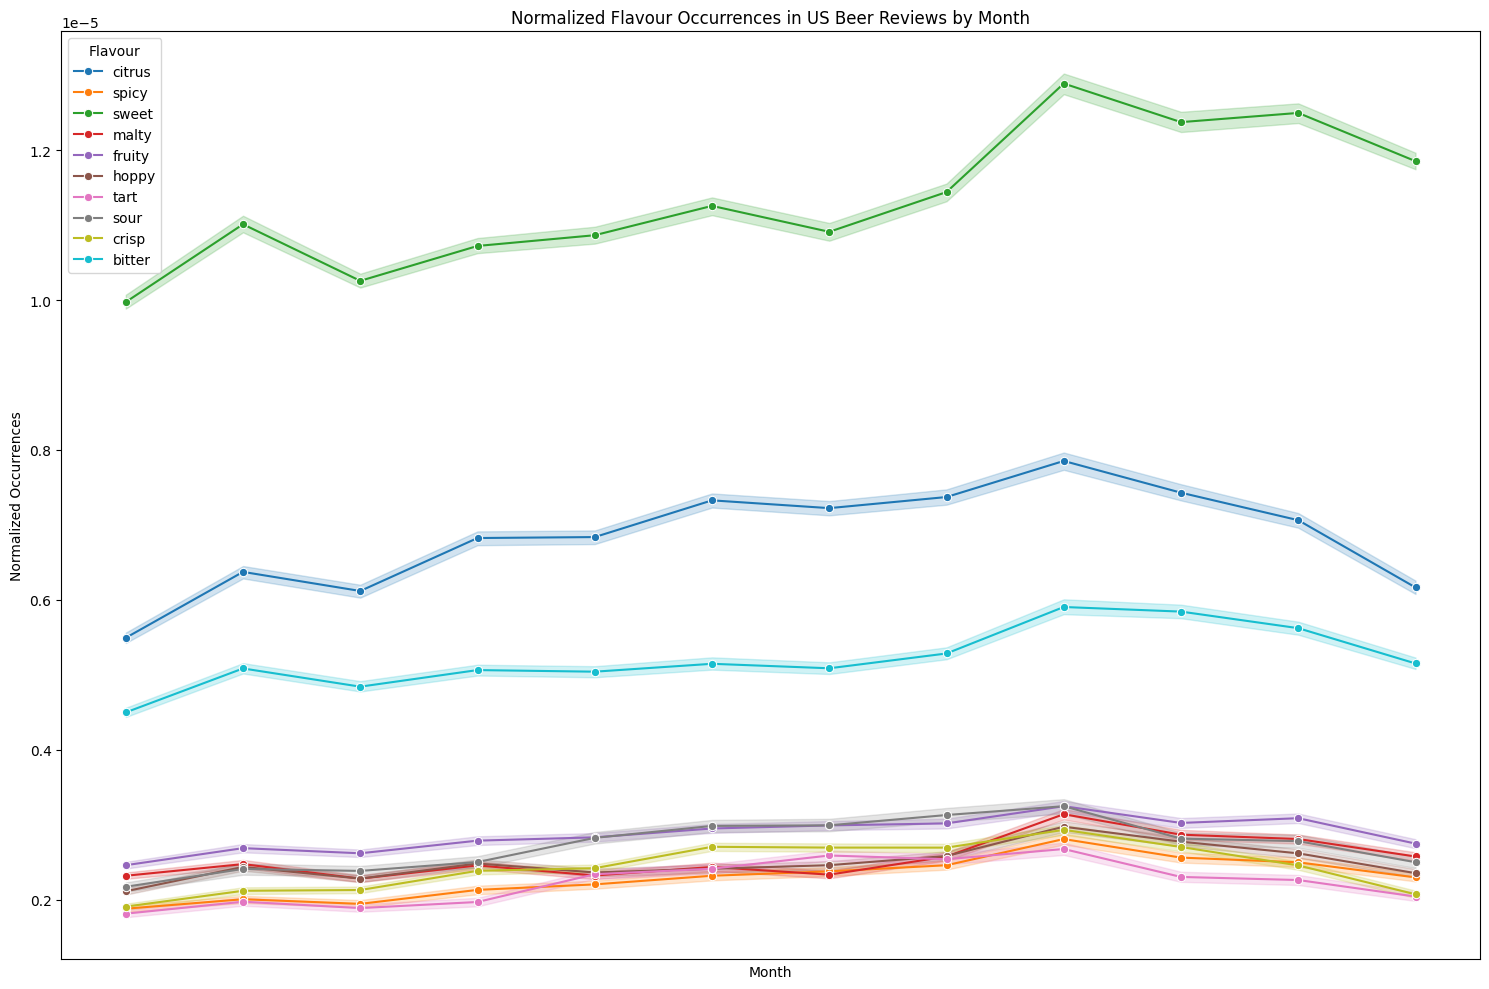

In [19]:
flavour_review = analyse_flavours(clean_reviews)

In [ ]:
sa.group_styles_by_flavours(flavour_review)